In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from imblearn.over_sampling import SMOTE
from collections import Counter

import joblib

In [2]:
data_origin = pd.read_csv('data-ori.csv')
data_origin

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,35.1,11.8,4.65,6.3,310,25.4,33.6,75.5,1,F,out
1,43.5,14.8,5.39,12.7,334,27.5,34.0,80.7,1,F,out
2,33.5,11.3,4.74,13.2,305,23.8,33.7,70.7,1,F,out
3,39.1,13.7,4.98,10.5,366,27.5,35.0,78.5,1,F,out
4,30.9,9.9,4.23,22.1,333,23.4,32.0,73.0,1,M,out
...,...,...,...,...,...,...,...,...,...,...,...
4407,32.8,10.4,3.49,8.1,72,29.8,31.7,94.0,92,F,in
4408,33.7,10.8,3.67,6.7,70,29.4,32.0,91.8,92,F,in
4409,33.2,11.2,3.47,7.2,235,32.3,33.7,95.7,93,F,out
4410,31.5,10.4,3.15,9.1,187,33.0,33.0,100.0,98,F,in


In [3]:
# the data is a little bit imbalanced
data_origin['SOURCE'].value_counts()

out    2628
in     1784
Name: SOURCE, dtype: int64

In [4]:
data_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4412 entries, 0 to 4411
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HAEMATOCRIT   4412 non-null   float64
 1   HAEMOGLOBINS  4412 non-null   float64
 2   ERYTHROCYTE   4412 non-null   float64
 3   LEUCOCYTE     4412 non-null   float64
 4   THROMBOCYTE   4412 non-null   int64  
 5   MCH           4412 non-null   float64
 6   MCHC          4412 non-null   float64
 7   MCV           4412 non-null   float64
 8   AGE           4412 non-null   int64  
 9   SEX           4412 non-null   object 
 10  SOURCE        4412 non-null   object 
dtypes: float64(7), int64(2), object(2)
memory usage: 379.3+ KB


In [5]:
data_origin.describe()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE
count,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000
mean,38.197688,12.741727,4.541260,8.718608,257.524479,28.234701,33.343042,84.612942,46.626473
std,5.974784,2.079903,0.784091,5.049041,113.972365,2.672639,1.228664,6.859101,21.731218
min,13.700000,3.800000,1.480000,1.100000,8.000000,14.900000,26.000000,54.000000,1.000000
25%,34.375000,11.400000,4.040000,5.675000,188.000000,27.200000,32.700000,81.500000,29.000000
50%,38.600000,12.900000,4.570000,7.600000,256.000000,28.700000,33.400000,85.400000,47.000000
75%,42.500000,14.200000,5.050000,10.300000,321.000000,29.800000,34.100000,88.700000,64.000000
max,69.000000,18.900000,7.860000,76.600000,1183.000000,40.800000,39.000000,115.600000,99.000000


In [6]:
data_origin.isna().sum()

HAEMATOCRIT     0
HAEMOGLOBINS    0
ERYTHROCYTE     0
LEUCOCYTE       0
THROMBOCYTE     0
MCH             0
MCHC            0
MCV             0
AGE             0
SEX             0
SOURCE          0
dtype: int64

In [7]:
# putting the target variable in a suitable format (from 'in' to 1, from 'out' to 0)
data_origin['SOURCE'] = np.where(data_origin['SOURCE'] == 'in', 1, 0)
data_origin

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,35.1,11.8,4.65,6.3,310,25.4,33.6,75.5,1,F,0
1,43.5,14.8,5.39,12.7,334,27.5,34.0,80.7,1,F,0
2,33.5,11.3,4.74,13.2,305,23.8,33.7,70.7,1,F,0
3,39.1,13.7,4.98,10.5,366,27.5,35.0,78.5,1,F,0
4,30.9,9.9,4.23,22.1,333,23.4,32.0,73.0,1,M,0
...,...,...,...,...,...,...,...,...,...,...,...
4407,32.8,10.4,3.49,8.1,72,29.8,31.7,94.0,92,F,1
4408,33.7,10.8,3.67,6.7,70,29.4,32.0,91.8,92,F,1
4409,33.2,11.2,3.47,7.2,235,32.3,33.7,95.7,93,F,0
4410,31.5,10.4,3.15,9.1,187,33.0,33.0,100.0,98,F,1


In [8]:
origin_copy = data_origin.copy()

X = origin_copy.drop(columns = ['SOURCE'], inplace = False)
y = data_origin['SOURCE']
X
display(y.value_counts())

0    2628
1    1784
Name: SOURCE, dtype: int64

In [9]:
# I've decided to drop the sex column, because it has no impact on the model, and this categorical variable would be harder to 
# handle with the flask application.
X.drop(columns = ['SEX'], inplace = True)

In [10]:
display(X)

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE
0,35.1,11.8,4.65,6.3,310,25.4,33.6,75.5,1
1,43.5,14.8,5.39,12.7,334,27.5,34.0,80.7,1
2,33.5,11.3,4.74,13.2,305,23.8,33.7,70.7,1
3,39.1,13.7,4.98,10.5,366,27.5,35.0,78.5,1
4,30.9,9.9,4.23,22.1,333,23.4,32.0,73.0,1
...,...,...,...,...,...,...,...,...,...
4407,32.8,10.4,3.49,8.1,72,29.8,31.7,94.0,92
4408,33.7,10.8,3.67,6.7,70,29.4,32.0,91.8,92
4409,33.2,11.2,3.47,7.2,235,32.3,33.7,95.7,93
4410,31.5,10.4,3.15,9.1,187,33.0,33.0,100.0,98


In [11]:
#SMOTE oversample - the random forest model has shown a better performance with this technique

oversample = SMOTE()
transformer = StandardScaler().fit(X)
Scaled_X = transformer.transform(X)
X_sm, y_sm = oversample.fit_resample(Scaled_X, y)
counter = Counter(y_sm)
print(counter)

Counter({0: 2628, 1: 2628})


In [12]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, test_size=0.3, random_state = 10)

The accuracy of the logistic_regression model is: 0.78 
[[624 159]
 [181 613]]


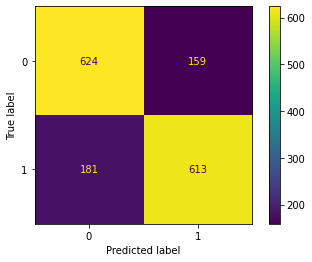

The Kappa of your model is: 0.57
              precision    recall  f1-score   support

           1       0.79      0.77      0.78       794
           0       0.78      0.80      0.79       783

    accuracy                           0.78      1577
   macro avg       0.78      0.78      0.78      1577
weighted avg       0.78      0.78      0.78      1577



In [13]:
clfr_sm = RandomForestClassifier(n_estimators = 500)
clfr_sm.fit(X_train_sm, y_train_sm)

y_pred_sm = clfr_sm.predict(X_test_sm)

print("The accuracy of the logistic_regression model is: %4.2f "% (clfr_sm.score(X_test_sm, y_test_sm)))

print(confusion_matrix(y_test_sm, y_pred_sm))
plot_confusion_matrix(clfr_sm, X_test_sm, y_test_sm)  # doctest: +SKIP
plt.show()  # doctest: +SKIP
print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(y_test_sm, y_pred_sm)))
print(classification_report(y_test_sm, y_pred_sm, labels=[1,0]))

In [14]:
feature_names = list(X.columns)


df = pd.DataFrame(list(zip(feature_names, clfr_sm.feature_importances_)))
df.columns = ['columns_name', 'score_feature_importance']
df.sort_values(by=['score_feature_importance'], ascending = False)

,columns_name,score_feature_importance
4,THROMBOCYTE,0.208168
3,LEUCOCYTE,0.125664
0,HAEMATOCRIT,0.122596
8,AGE,0.104563
2,ERYTHROCYTE,0.101542
1,HAEMOGLOBINS,0.090297
7,MCV,0.088621
6,MCHC,0.081377
5,MCH,0.077172


In [15]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, test_size=0.3, random_state = 10)

The accuracy of the Random Forest model is: 0.77 
[[572 211]
 [158 636]]


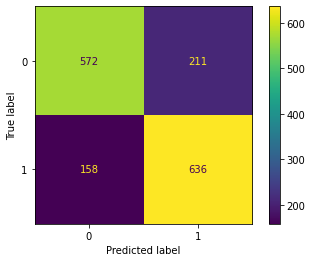

The Kappa of your model is: 0.53
              precision    recall  f1-score   support

           1       0.75      0.80      0.78       794
           0       0.78      0.73      0.76       783

    accuracy                           0.77      1577
   macro avg       0.77      0.77      0.77      1577
weighted avg       0.77      0.77      0.77      1577



In [16]:
clfr_sm = RandomForestClassifier(n_estimators =2000, class_weight={1: 0.05, 0: 70})
clfr_sm.fit(X_train_sm, y_train_sm)

y_pred_sm = clfr_sm.predict(X_test_sm)

print("The accuracy of the Random Forest model is: %4.2f "% (clfr_sm.score(X_test_sm, y_test_sm)))

print(confusion_matrix(y_test_sm, y_pred_sm))
plot_confusion_matrix(clfr_sm, X_test_sm, y_test_sm)  # doctest: +SKIP
plt.show()  # doctest: +SKIP
print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(y_test_sm, y_pred_sm)))
print(classification_report(y_test_sm, y_pred_sm, labels=[1,0]))

In [17]:
from sklearn.model_selection import cross_val_score

from scipy.stats import t, norm

print("The accuracy of the Random forest is: {:4.2f}".format(clfr_sm.score(X_test_sm, y_test_sm)))
print()

alpha = 0.05
K = 10
# For cross validation
cross_val_scores = cross_val_score(clfr_sm, X_train_sm, y_train_sm, cv=10)

if (K < 30):
    t_critical = abs(t.ppf(alpha, K-1))
    interval = t_critical*(np.std(cross_val_score(clfr_sm, X_train_sm, y_train_sm, cv=10))/np.sqrt(K))
else:
    z_critical = abs(norm.ppf(1-alpha/2))
    interval = z_critical*(np.std(cross_val_score(clfr_sm, X_train_sm, y_train_sm, cv=10))/np.sqrt(K)) 
print("The accuracy of the Random Forest model (CV witk K=10) is: {:4.2f} +/- {:4.2f}".format(np.mean(cross_val_scores),interval))

The accuracy of the Random forest is: 0.77

The accuracy of the Random Forest model (CV witk K=10) is: 0.75 +/- 0.01


#### I already saved the best performing model while doing previous testing, and after that I overriden the model definition multiple times.
#### So below I will just provide a testing of the saved model in order to show its error metrics

In [18]:
#filename = 'Class_4_smote_rf_full_data_class_weights_small+.sav'
#joblib.dump(clfr_sm, open(filename, 'wb'))

In [19]:
file_name = 'Class_4_smote_rf_full_data_class_weights_small+.sav'
random_Forest = joblib.load(open(file_name, 'rb'))

The accuracy of the logistic_regression model is: 0.77 
[[579 204]
 [151 643]]


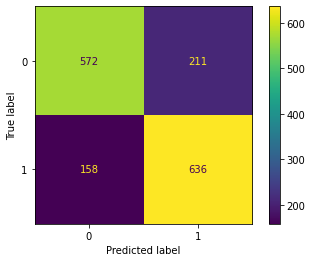

The Kappa of your model is: 0.55
              precision    recall  f1-score   support

           1       0.76      0.81      0.78       794
           0       0.79      0.74      0.77       783

    accuracy                           0.77      1577
   macro avg       0.78      0.77      0.77      1577
weighted avg       0.78      0.77      0.77      1577



In [20]:
y_pred_sm = random_Forest.predict(X_test_sm)

print("The accuracy of the logistic_regression model is: %4.2f "% (clfr_sm.score(X_test_sm, y_test_sm)))

print(confusion_matrix(y_test_sm, y_pred_sm))
plot_confusion_matrix(clfr_sm, X_test_sm, y_test_sm)  # doctest: +SKIP
plt.show()  # doctest: +SKIP
print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(y_test_sm, y_pred_sm)))
print(classification_report(y_test_sm, y_pred_sm, labels=[1,0]))

In [21]:
print("The accuracy of the Random forest is: {:4.2f}".format(random_Forest.score(X_test_sm, y_test_sm)))
print()

alpha = 0.05
K = 10
# For cross validation
cross_val_scores = cross_val_score(random_Forest, X_train_sm, y_train_sm, cv=10)

if (K < 30):
    t_critical = abs(t.ppf(alpha, K-1))
    interval = t_critical*(np.std(cross_val_score(random_Forest, X_train_sm, y_train_sm, cv=10))/np.sqrt(K))
else:
    z_critical = abs(norm.ppf(1-alpha/2))
    interval = z_critical*(np.std(cross_val_score(random_Forest, X_train_sm, y_train_sm, cv=10))/np.sqrt(K)) 
print("The accuracy of the Random Forest model (CV witk K=10) is: {:4.2f} +/- {:4.2f}".format(np.mean(cross_val_scores),interval))

The accuracy of the Random forest is: 0.77

The accuracy of the Random Forest model (CV witk K=10) is: 0.76 +/- 0.01
